**Regularized Linear Models** (https://www.kaggle.com/apapiu/regularized-linear-models)

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import skew
from scipy.stats.stats import pearsonr

# %config InlineBackend.figure_format = 'png'

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
all_data = pd.concat((train.iloc[:, 1:-1] , test.iloc[:, 1:]))

## Preprocessing
1. Skewed Numerical featuresをlogに置換する。
2. Create Dummy variables for the Categorical features
3. 欠損値をmeanで埋める。

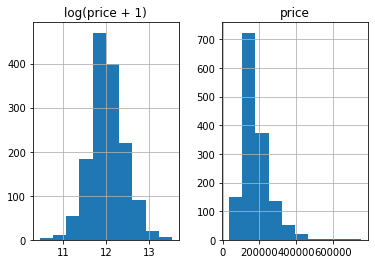

In [6]:
prices = pd.DataFrame({'price': train['SalePrice'], 
                                           'log(price + 1)': np.log1p(train['SalePrice'])})
prices.hist();

In [7]:
train["SalePrice"] = np.log1p(train["SalePrice"])

In [8]:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index

In [9]:
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[abs(skewed_feats) > 0.75].index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [10]:
all_data = pd.get_dummies(all_data)

In [11]:
all_data.fillna(all_data.mean(), inplace=True)

## モデリング

In [12]:
X_train = all_data[: train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train['SalePrice']

In [13]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, Lasso
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(- cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

> **neg_mean_squared_error** ... \
cross_val_score ( scoring= )　\
scoringパラメータを使用して得点オブジェクトを指定することができる。\
より高い返り値が低い返り値よりも優れている という規則に従う。\
したがって、 mean_squared_error のように、モデルとデータの間の距離を測定するメトリックは、メトリックの否定された値を返す neg_mean_squared_errorとして利用できる。

## Ridge()
The main tuning parameter for the Ridge model is **alpha** - a regularization parameter that measures how flexible our model is. **The higher the regularization the less prone our model will be to overfit.** However it will also lose flexibility and might not capture all of the signal in the data.

Text(0, 0.5, 'rmse')

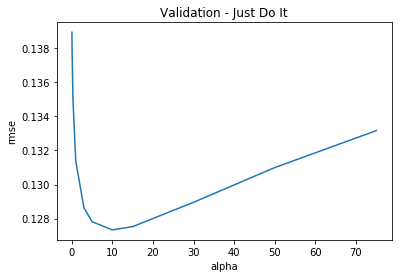

In [14]:
model_ridge = Ridge()

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title='Validation - Just Do It')
plt.xlabel('alpha')
plt.ylabel('rmse')

When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. \
A value of alpha = 10 is about right based on the plot above.

In [15]:
cv_ridge.min()

0.12733734668670774

## LassoCV()
alphasはRidgeと反対で小さいほど過学習を抑えられる。しかし小さ過ぎても良くない。

In [16]:
model_lasso = LassoCV(alphas=[1, 0.1, 0.001, 0.0005]).fit(X_train, y)

rmse_cv(model_lasso).mean()

# model_lasso = Lasso()

# alphas=[1, 0.1, 0.001, 0.0005]
# cv_lasso = [rmse_cv(Lasso(alpha=alpha)).mean() for alpha in alphas]
# cv_lasso= pd.Series(cv_lasso, index=alphas)
# cv_lasso.plot()

# cv_lasso.min()  0.12256735885048124

0.12256735885048124

Lassoのほうが数字が良い。\
Lassoの良いところは不要な変数を取り除いてくれる(=0)

In [17]:
coef = pd.Series(model_lasso.coef_, index=X_train.columns)
print('Lasso picked' + str((coef != 0).sum()) \
      + 'variables and elminated the other' + str((coef == 0).sum()) + 'variables')

Lasso picked110variables and elminated the other178variables


In [18]:
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
imp_coef

RoofMatl_ClyTile        -0.704161
MSZoning_C (all)        -0.292023
Condition2_PosN         -0.190552
Neighborhood_Edwards    -0.052560
SaleCondition_Abnorml   -0.047116
MSZoning_RM             -0.037698
CentralAir_N            -0.035440
GarageCond_Fa           -0.031688
LandContour_Bnk         -0.030934
SaleType_WD             -0.030656
OverallQual              0.053160
KitchenQual_Ex           0.063709
Exterior1st_BrkFace      0.070464
Neighborhood_NridgHt     0.071620
LotArea                  0.071826
Functional_Typ           0.072597
Neighborhood_NoRidge     0.085717
Neighborhood_Crawfor     0.105138
Neighborhood_StoneBr     0.112493
GrLivArea                0.400009
dtype: float64

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

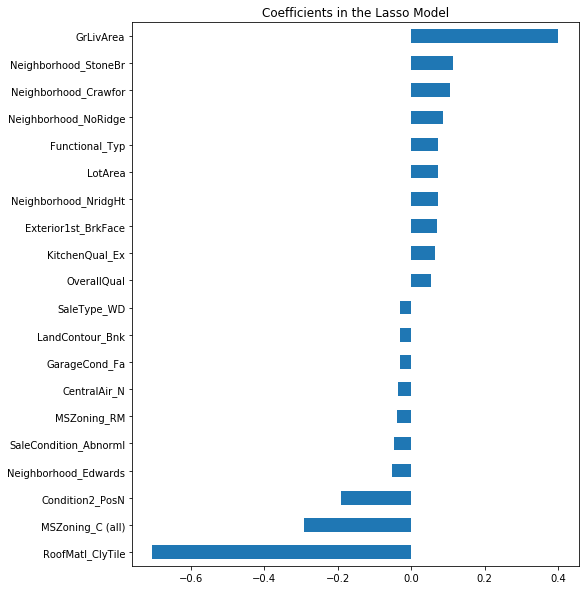

In [19]:
plt.figure(figsize=(8, 10))
imp_coef.plot(kind='barh')
plt.title('Coefficients in the Lasso Model')

### ※? The only issue here is that we log_transformed both the target and the numeric features so the actual magnitudes are a bit hard to interpret.

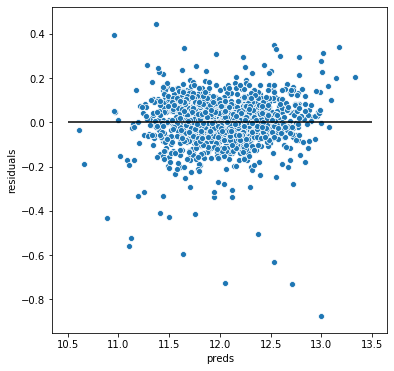

In [20]:
preds = pd.DataFrame({'preds': model_lasso.predict(X_train), 'true': y})
preds['residuals'] = preds['true'] - preds['preds']

plt.figure(figsize=(6,6))
sns.scatterplot(x='preds', y='residuals', data=preds)
plt.hlines(y=0, xmin=10.5, xmax=13.5)

## xgboost

In [21]:
import xgboost as xgb

In [22]:
dtrain = xgb.DMatrix(X_train, label=y)
dtest = xgb.DMatrix(X_test)

params = {'max_depth': 2, 'eta': 0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=100)

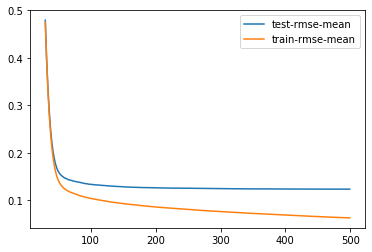

In [23]:
model.loc[30:, ['test-rmse-mean', 'train-rmse-mean']].plot()

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
model_xgb.fit(X_train, y)

[18:09:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

> **expm1(x)** は e の x 乗から 1 を引いた値 \
非常に小さな x で exp(x) - 1 を計算すると、-1により桁落ちするが、expm1関数は精度を保つ

In [ ]:
predictions = pd.DataFrame({'xgb': xgb_preds, 'lasso': lasso_preds})
sns.scatterplot(x='xgb', y='lasso', data=predictions)

# ※? Many times it makes sense to take a weighted average of uncorrelated results - this usually imporoves the score

In [ ]:
preds = 0.7*lasso_preds + 0.3*xgb_preds